# Convolutional autoencoders and LSTMs for PDE surrogates

In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Load SWE snapshot data - training

In [3]:
num_sims = 10
for sim in range(num_sims):
    filename = 'snapshot_matrix_pod_'+str(sim+1)+'.npy'
    
    if sim == 0:
        swe_data_sim = np.transpose(np.load(filename))[0:200,:]
    else:
        swe_data_temp = np.transpose(np.load(filename))[0:200,:]
        swe_data_sim = np.concatenate((swe_data_sim,swe_data_temp),axis=0)

scaler = StandardScaler()
swe_data_sim = scaler.fit_transform(swe_data_sim)
        
swe_train_data = np.zeros(shape=(np.shape(swe_data_sim)[0],64,64,3)) # Channels last
for i in range(np.shape(swe_data_sim)[0]):
    temp_1 = swe_data_sim[i,0:64*64].reshape(64,64)
    temp_2 = swe_data_sim[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data_sim[i,2*64*64:3*64*64].reshape(64,64)
    swe_train_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_train_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_train_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
# All training data loaded

### Load SWE snapshot data - validation

In [4]:
filename = 'snapshot_matrix_pod_test.npy'
swe_data_temp = np.transpose(np.load(filename))[0:200,:]
swe_data_temp = scaler.transform(swe_data_temp)

swe_data_test = np.zeros(shape=(np.shape(swe_data_temp)[0],64,64,3)) # Channels last

for i in range(np.shape(swe_data_test)[0]):
    temp_1 = swe_data_temp[i,0:64*64].reshape(64,64)
    temp_2 = swe_data_temp[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data_temp[i,2*64*64:3*64*64].reshape(64,64)
    swe_data_test[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_data_test[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_data_test[i,:,:,2] = np.transpose(temp_3[:,:])

### Visualize snapshots

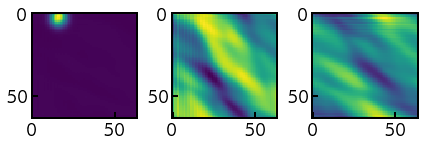

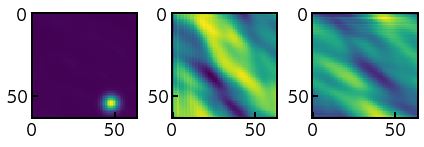

In [5]:
# Visualize one time instance of training
time = 0
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_train_data[time,:,:,0])
ax[1].imshow(swe_train_data[time,:,:,1])
ax[2].imshow(swe_train_data[time,:,:,2])
plt.tight_layout()
plt.show()

# Visualize one time instance of testing
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_data_test[time,:,:,0])
ax[1].imshow(swe_data_test[time,:,:,1])
ax[2].imshow(swe_data_test[time,:,:,2])
plt.tight_layout()
plt.show()


### Some global variables

In [6]:
time_window = 20 # The window size of the LSTM
mode = 'test'

### ML related presets

In [7]:
lrate = 0.001

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Autoencoder

In [8]:
# Define model architecture
weights_filepath = 'best_weights_ae.h5'
## Encoder
encoder_inputs = Input(shape=(64,64,3),name='Field')
# Encode   
x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(12,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

encoder = Model(inputs=encoder_inputs,outputs=encoded)
    
## Decoder
decoder_inputs = Input(shape=(2,2,3),name='decoded')

x = Conv2D(3,kernel_size=(3,3),activation='relu',padding='same')(decoder_inputs)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(12,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')(dec_l5)
    
decoder = Model(inputs=decoder_inputs,outputs=decoded)

## Autoencoder
ae_outputs = decoder(encoder(encoder_inputs))
  
model = Model(inputs=encoder_inputs,outputs=ae_outputs,name='CAE')

plot_model(encoder,to_file='Encoder.png')
plot_model(decoder,to_file='Decoder.png')
    
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])    
model.summary()

num_epochs = 5000
batch_size = 10

if mode == 'train':
    train_history = model.fit(x=swe_train_data, y=swe_train_data, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)

W0129 09:55:25.237083 140330763106112 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Field (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
model (Model)                (None, 2, 2, 3)           6270      
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         6354      
Total params: 12,624
Trainable params: 12,624
Non-trainable params: 0
_________________________________________________________________


### Check accuracy on training

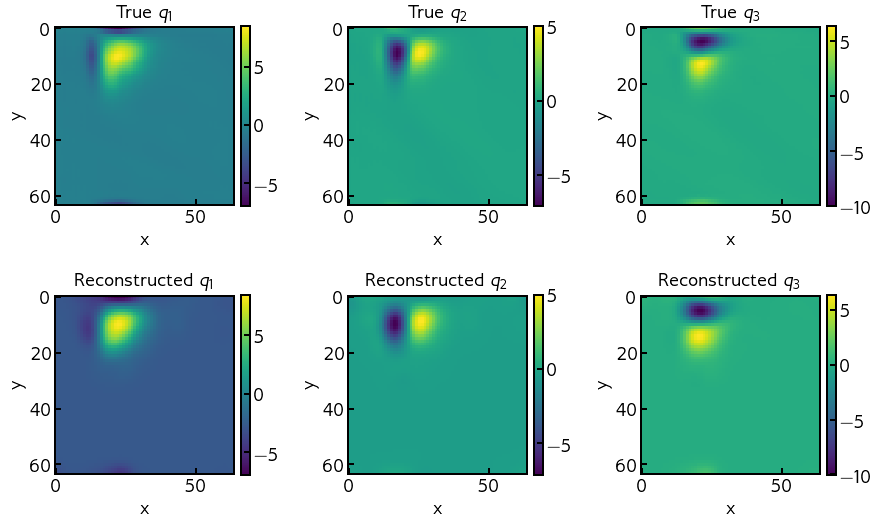

In [9]:
model.load_weights(weights_filepath)
from scipy.ndimage import gaussian_filter
time = 10
recoded_1 = model.predict(swe_train_data[time:time+1,:,:,:])

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_train_data[time,:,:,0],label='input')
ax[1,0].imshow(gaussian_filter(recoded_1[0,:,:,0],sigma=2),label='decoded')

cs2 = ax[0,1].imshow(swe_train_data[time,:,:,1],label='input')
ax[1,1].imshow(gaussian_filter(recoded_1[0,:,:,1],sigma=2),label='decoded')

cs3 = ax[0,2].imshow(swe_train_data[time,:,:,2],label='input')
ax[1,2].imshow(gaussian_filter(recoded_1[0,:,:,2],sigma=2),label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
# plt.tight_layout()
plt.show()

### Check accuracy on validation

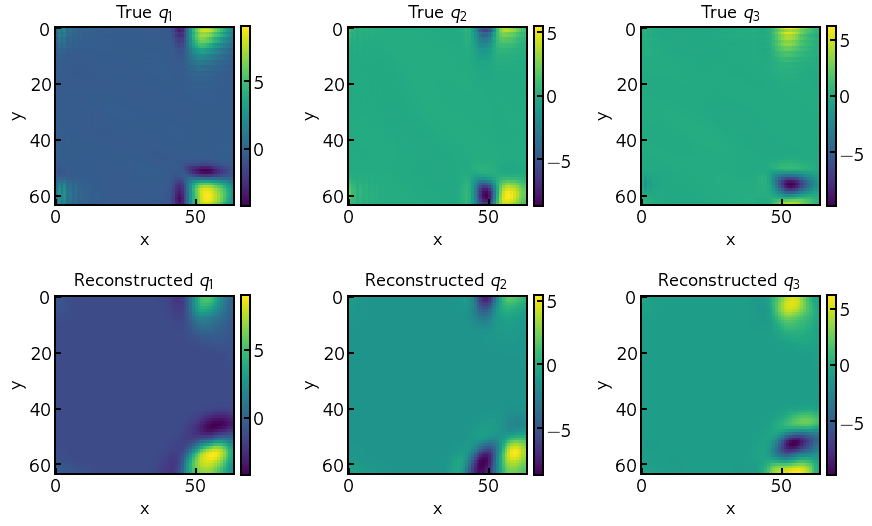

In [10]:
time = 10
recoded_1 = model.predict(swe_data_test[time:time+1,:,:,:])

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_data_test[time,:,:,0],label='input')
ax[1,0].imshow(gaussian_filter(recoded_1[0,:,:,0],sigma=2),label='decoded')

cs2 = ax[0,1].imshow(swe_data_test[time,:,:,1],label='input')
ax[1,1].imshow(gaussian_filter(recoded_1[0,:,:,1],sigma=2),label='decoded')

cs3 = ax[0,2].imshow(swe_data_test[time,:,:,2],label='input')
ax[1,2].imshow(gaussian_filter(recoded_1[0,:,:,2],sigma=2),label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
# plt.tight_layout()
plt.show()

### Generate encoded data for LSTM learning

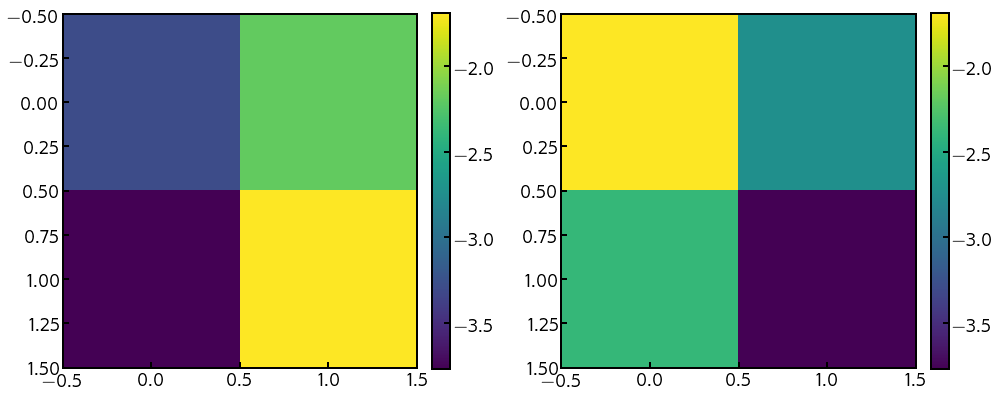

In [11]:
encoded = K.eval(encoder(swe_train_data[:,:,:,:].astype('float32')))
# Latent space
# print(np.shape(encoded))

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
time = 98
cs = ax[0].imshow(encoded[time,:,:,0])
fig.colorbar(cs,ax=ax[0],fraction=0.046, pad=0.04)

time = 198
ax[1].imshow(encoded[time,:,:,0])
fig.colorbar(cs,ax=ax[1],fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Add parameter information

In [12]:
# Add parameter information
parameters = np.asarray([[-0.45, -0.25],[-0.15,  0.35],[-0.05, -0.45],[ 0.15,  0.45],
        [ 0.05,  0.15],[-0.35,  0.05],[ 0.35, -0.05],[-0.25, -0.15],[ 0.45,  0.25],
        [ 0.25, -0.35]])

### Train LSTM

In [13]:
lstm_training_data = np.copy(encoded)
num_train_snapshots = 10
total_size = np.shape(lstm_training_data)[0]*np.shape(lstm_training_data)[1]

# Rescale
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scale_lstm = False
if scale_lstm:
    scaler = StandardScaler()
    lstm_training_data_scaled = scaler.fit_transform(lstm_training_data[:,:])
else:
    lstm_training_data_scaled = lstm_training_data[:,:]
    
lstm_training_data_scaled = lstm_training_data_scaled.reshape(10,200,12)

# Shape the inputs and outputs
input_seq = np.zeros(shape=(total_size-time_window*num_train_snapshots,time_window,14))
output_seq = np.zeros(shape=(total_size-time_window*num_train_snapshots,12))

# Setting up inputs
sample = 0
for snapshot in range(num_train_snapshots):
    lstm_snapshot = lstm_training_data_scaled[snapshot,:,:]
    for t in range(time_window,200):
        input_seq[sample,:,:12] = lstm_snapshot[t-time_window:t,:]
        input_seq[sample,:,12:] = parameters[snapshot,:]
        output_seq[sample,:] = lstm_snapshot[t,:]
        sample = sample + 1

In [14]:
# Saving all the training data (for future use)
parameter_info = np.zeros(shape=(10,200,2),dtype='double')
# Setting up inputs
sample = 0
for snapshot in range(num_train_snapshots):
    for t in range(200):
        parameter_info[snapshot,:,:] = parameters[snapshot,:]
        
total_training_data = np.concatenate((lstm_training_data_scaled,parameter_info),axis=-1)
np.save('Times_Series_Training_Data.npy',total_training_data)

In [15]:
# Model architecture
lstm_model = models.Sequential()
lstm_model.add(LSTM(50,input_shape=(time_window, 14),return_sequences=True))  #
lstm_model.add(LSTM(50,input_shape=(time_window, 14),return_sequences=True))  #
lstm_model.add(LSTM(50,input_shape=(time_window, 14),return_sequences=False))  #
lstm_model.add(Dense(12, activation=None))

# training parameters
num_epochs = 200
batch_size = 64


# design network
lstm_filepath = 'lstm_weights.h5'
lstm_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
checkpoint = ModelCheckpoint(lstm_filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
lstm_callbacks_list = [checkpoint]

# fit network
lstm_model.compile(optimizer=lstm_adam,loss='mean_squared_error',metrics=[coeff_determination])

if mode == 'train':
    lstm_train_history = lstm_model.fit(input_seq, output_seq, epochs=num_epochs, batch_size=batch_size, callbacks=lstm_callbacks_list)

### Test LSTM with parameter information - on training data (stability)

In [16]:
lstm_model.load_weights(lstm_filepath)
# lstm_model.load_weights('lstm_weights_best.h5')

# Shape the inputs and outputs
input_seq = np.zeros(shape=(1,time_window,14))
output_seq_pred = np.zeros(shape=(200,12))

# Setting up inputs
sample = 0
input_seq[0,:,:] = total_training_data[0,0:time_window,:]
input_seq[0,:,12] = total_training_data[0,0,12]
input_seq[0,:,13] = total_training_data[0,0,13]

output_seq_pred[:,:] = total_training_data[0,:,:12]

for t in range(time_window,200):
    output_seq_pred[t,:] = lstm_model.predict(input_seq[0:1,:,:])[0,:]
    input_seq[0,0:time_window-1,:12] = input_seq[0,1:,:12] 
    input_seq[0,time_window-1,:12] = output_seq_pred[t,:]
    sample = sample + 1

### Check quality in latent space for training data

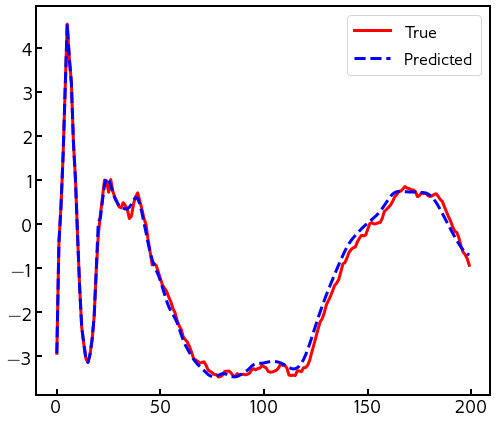

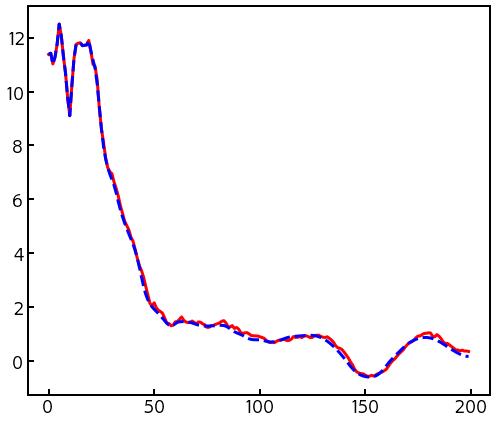

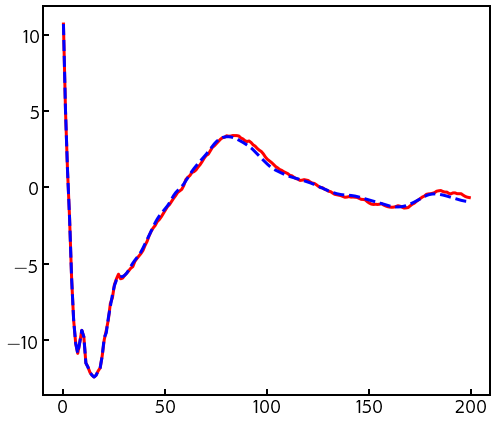

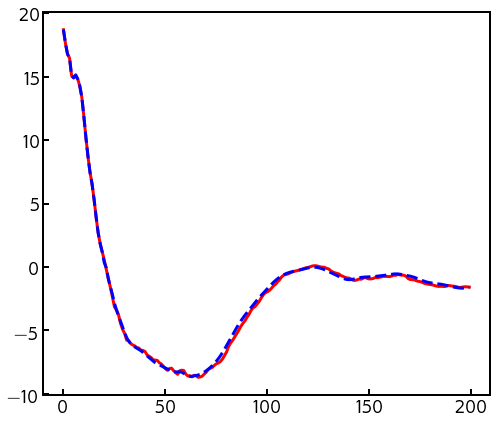

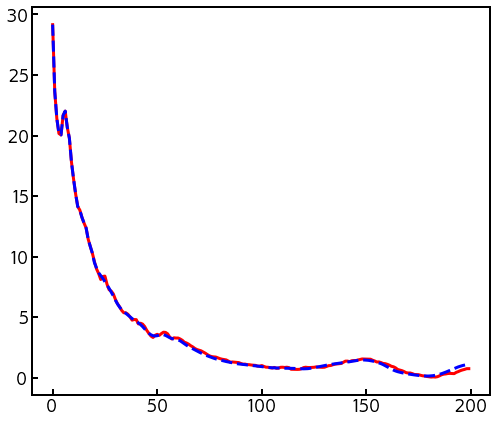

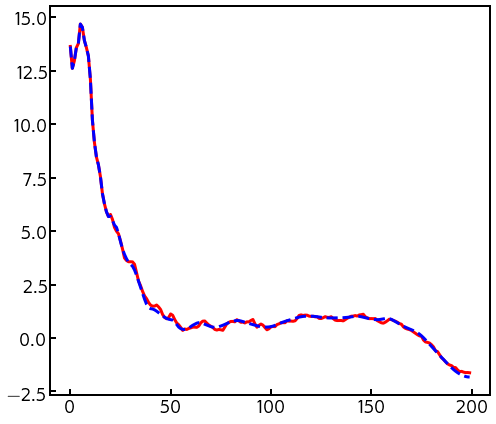

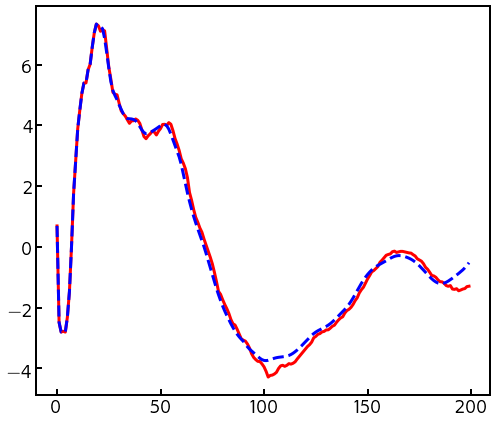

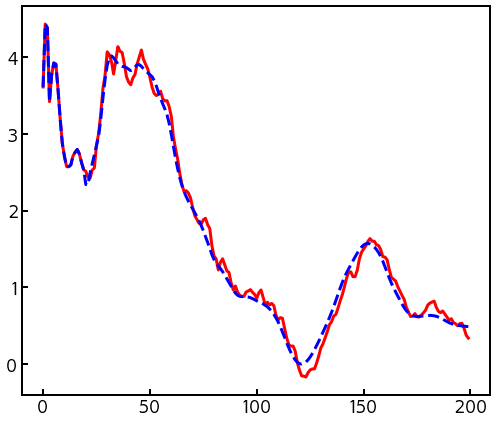

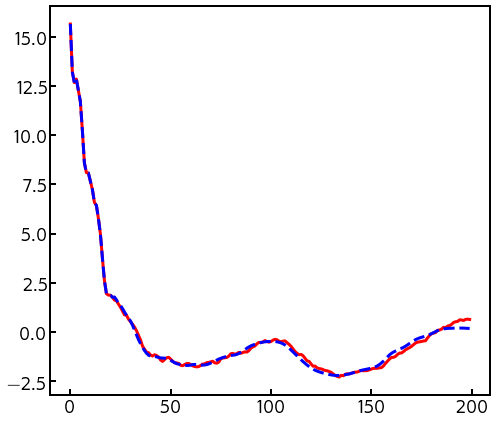

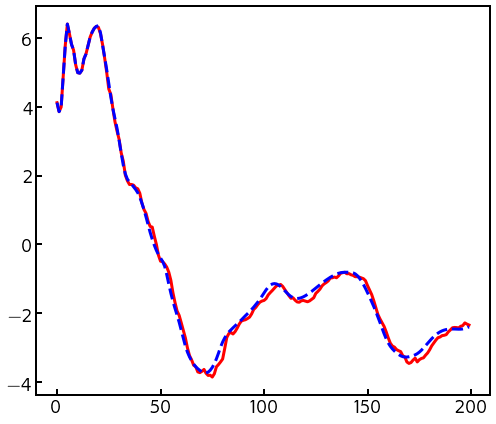

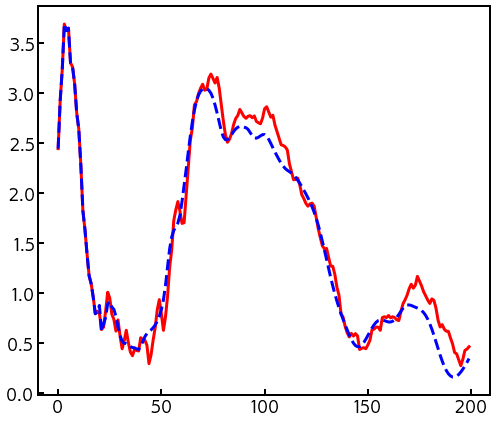

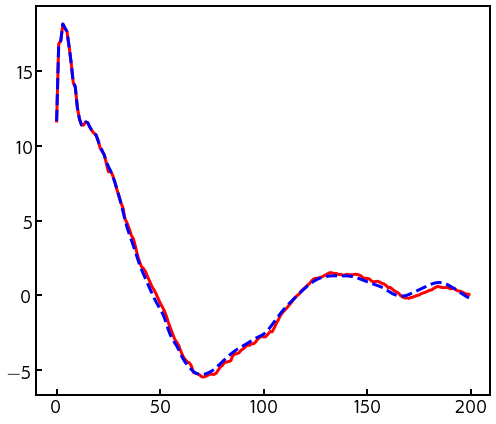

In [17]:
for i in range(12):
    plt.figure(figsize=(7,6))
    plt.plot(total_training_data[0,:,i],'r',label='True',linewidth=3)
    plt.plot(output_seq_pred[:,i],'b--',label='Predicted',linewidth=3)
    
    if i == 0:
        plt.legend()
    plt.tight_layout()
    plt.savefig('Training_LS_LSTM_'+str(i)+'.png')
    plt.show()

### Test LSTM with parameter information

In [18]:
encoded_valid = K.eval(encoder(swe_data_test[:,:,:,:].astype('float32')))
encoded_valid = encoded_valid.reshape(1,200,12)
lstm_testing_data = np.copy(encoded_valid)

num_test_snapshots = 1

# Shape the inputs and outputs
input_seq = np.zeros(shape=(1,time_window,14))
output_seq_pred = np.zeros(shape=(200,12))

# Setting up inputs
sample = 0
input_seq[0,:,:12] = lstm_testing_data[0,0:time_window,:]
input_seq[0,:,12] = 1.0/2.7
input_seq[0,:,13] = 1.0/4.0

output_seq_pred[:time_window,:] = lstm_testing_data[0,:time_window,:]

for t in range(time_window,200):
    output_seq_pred[t,:] = lstm_model.predict(input_seq[0:1,:,:])[0,:]
    input_seq[0,0:time_window-1,:12] = input_seq[0,1:,:12] 
    input_seq[0,time_window-1,:12] = output_seq_pred[t,:]
    sample = sample + 1

### Check quality in latent space for testing data

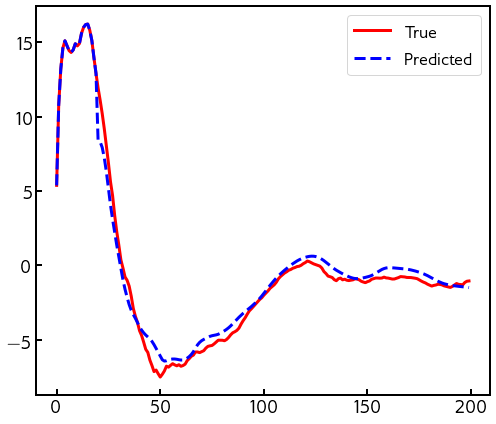

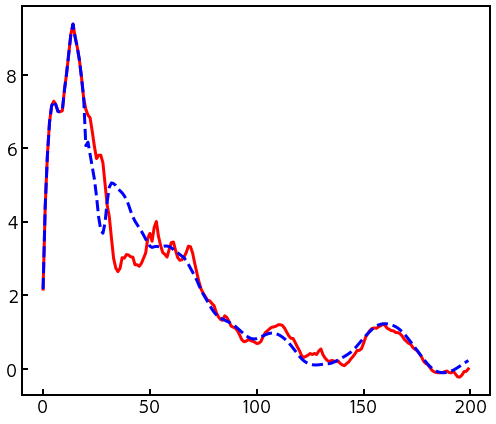

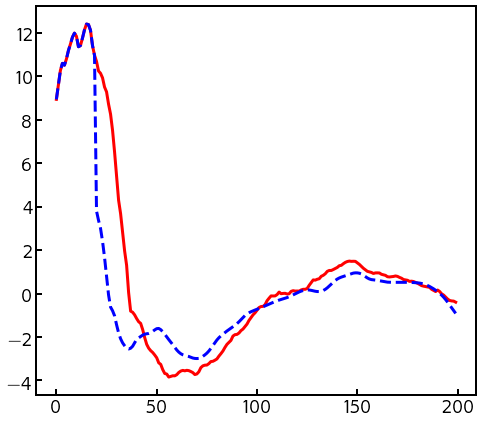

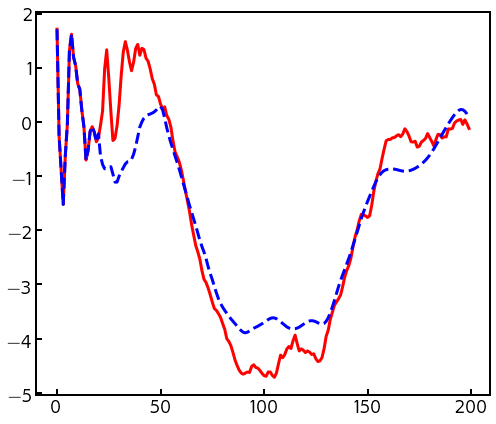

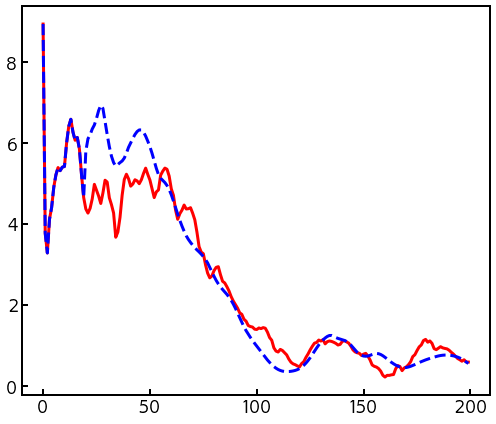

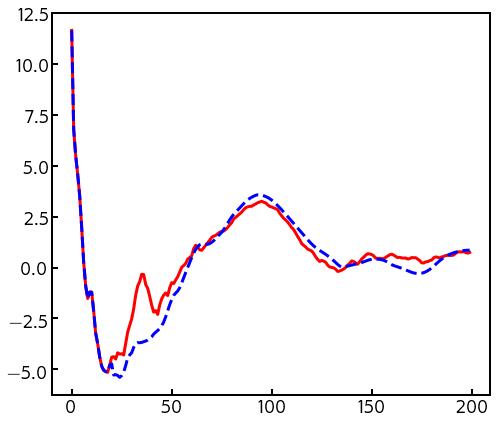

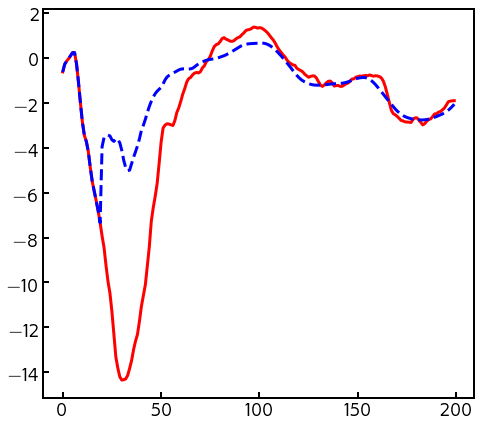

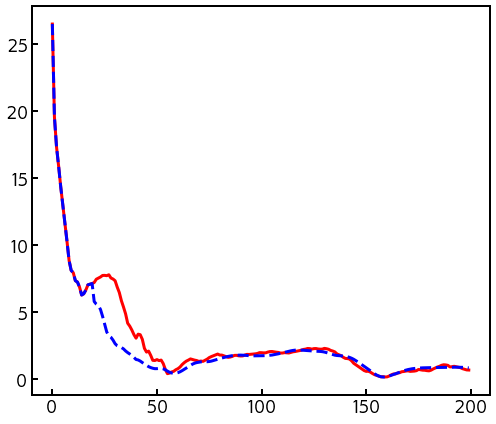

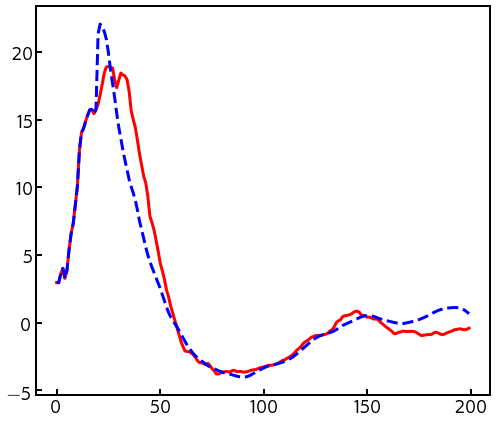

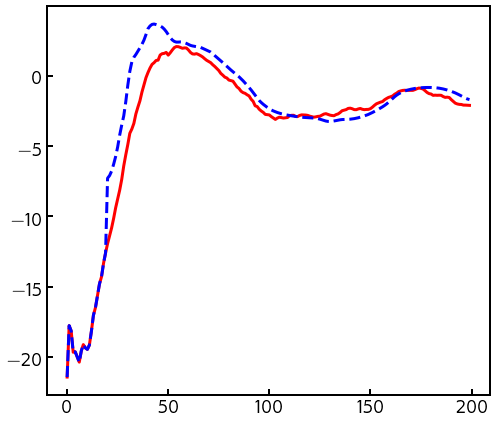

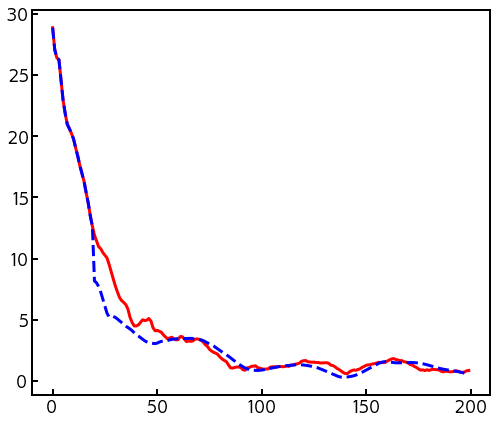

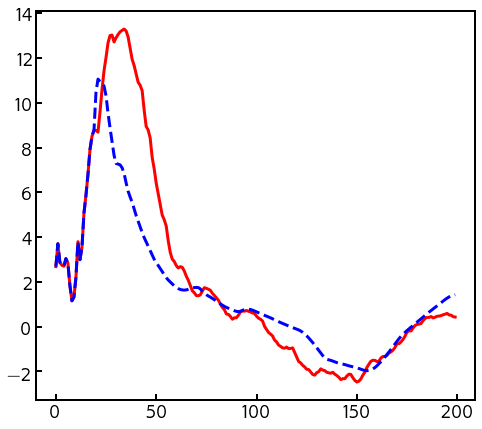

In [19]:
for i in range(12):
    plt.figure(figsize=(7,6))
    plt.plot(lstm_testing_data[0,:,i],'r',label='True',linewidth=3)
    plt.plot(output_seq_pred[:,i],'b--',label='Predicted',linewidth=3)
    
    if i == 0:
        plt.legend()
    plt.tight_layout()
    plt.savefig('Testing_LS_LSTM_'+str(i)+'.png')
    plt.show()

In [20]:
# Saving all the testing data (for future use)
parameter_info = np.zeros(shape=(1,200,2),dtype='double')
# Setting up inputs
parameter_info[0,:,0] = 1.0/2.7
parameter_info[0,:,1] = 1.0/4.0
    
time_series_testing_data = np.concatenate((lstm_testing_data,parameter_info),axis=-1)
np.save('Times_Series_Testing_Data.npy',time_series_testing_data)

In [21]:
output_seq_pred = np.reshape(output_seq_pred,newshape=(200,2,2,3))
print(np.shape(output_seq_pred))

(200, 2, 2, 3)


### Evolution in physical space

In [55]:
# Load GP data
q1_snapshots_gp = np.load('q1_snapshots_gp.npy')
q2_snapshots_gp = np.load('q2_snapshots_gp.npy')
q3_snapshots_gp = np.load('q3_snapshots_gp.npy')

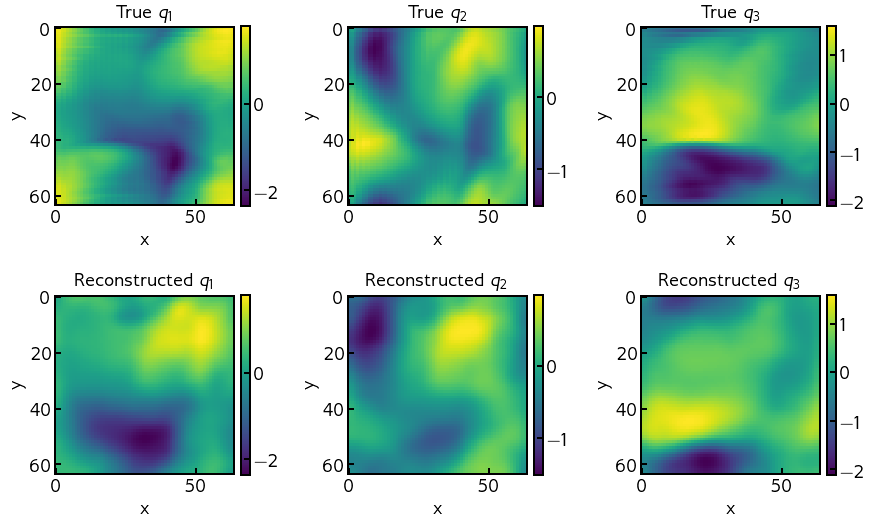

In [65]:
decoded_valid = K.eval(decoder(output_seq_pred.astype('float32')))
time = 199

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))
cs1 = ax[0,0].imshow(swe_data_test[time,:,:,0],label='Truth')
ax[1,0].imshow(gaussian_filter(decoded_valid[time,:,:,0],sigma=2),label='Prediction')

cs2 = ax[0,1].imshow(swe_data_test[time,:,:,1],label='Truth')
ax[1,1].imshow(gaussian_filter(decoded_valid[time,:,:,1],sigma=2),label='Prediction')

cs3 = ax[0,2].imshow(swe_data_test[time,:,:,2],label='Truth')
ax[1,2].imshow(gaussian_filter(decoded_valid[time,:,:,2],sigma=2),label='Prediction')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
# plt.tight_layout()
plt.show()

### Save the data for posterity

In [23]:
np.save('Testing_Data_Field_True.npy',swe_data_test)
np.save('Testing_Data_Field_Prediction.npy',decoded_valid)

### A posteriori analysis

In [50]:
snapshot_test_true = np.load('Testing_Data_Field_True.npy')
snapshot_test_pred = np.load('Testing_Data_Field_Prediction.npy')

# Inverse transform
snapshot_test_true = np.reshape(snapshot_test_true,newshape=(200,64*64*3),order='F')
snapshot_test_pred = np.reshape(snapshot_test_pred,newshape=(200,64*64*3),order='F')

snapshot_test_true = scaler.inverse_transform(snapshot_test_true)
snapshot_test_pred = scaler.inverse_transform(snapshot_test_pred)

snapshot_test_true = np.reshape(snapshot_test_true,newshape=(200,64,64,3),order='F')
snapshot_test_pred = np.reshape(snapshot_test_pred,newshape=(200,64,64,3),order='F')

np.save('Testing_Data_Field_True_Viz.npy',snapshot_test_true)

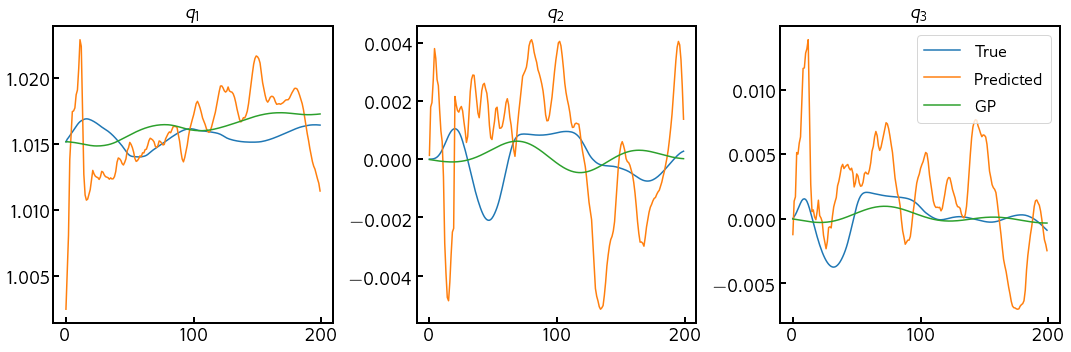

In [49]:
# Make some plots for field values
probe_data_true = np.mean(np.copy(snapshot_test_true).reshape(200,64*64,3,order='C'),axis=1)
probe_data_pred = np.mean(np.copy(snapshot_test_pred).reshape(200,64*64,3,order='C'),axis=1)
probe_data_gp_q1 = np.mean(np.copy(q1_snapshots_gp),axis=0)
probe_data_gp_q2 = np.mean(np.copy(q2_snapshots_gp),axis=0)
probe_data_gp_q3 = np.mean(np.copy(q3_snapshots_gp),axis=0)

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax[0].plot(probe_data_true[:,0],label='True')
ax[0].plot(probe_data_pred[:,0],label='Predicted')
ax[0].plot(probe_data_gp_q1[:],label='GP')
ax[0].set_title(r'$q_1$')

ax[1].plot(probe_data_true[:,1],label='True')
ax[1].plot(probe_data_pred[:,1],label='Predicted')
ax[1].plot(probe_data_gp_q2[:],label='GP')
ax[1].set_title(r'$q_2$')

ax[2].plot(probe_data_true[:,2],label='True')
ax[2].plot(probe_data_pred[:,2],label='Predicted')
ax[2].plot(probe_data_gp_q3[:],label='GP')
ax[2].set_title(r'$q_3$')

plt.legend()
plt.tight_layout()
plt.show()

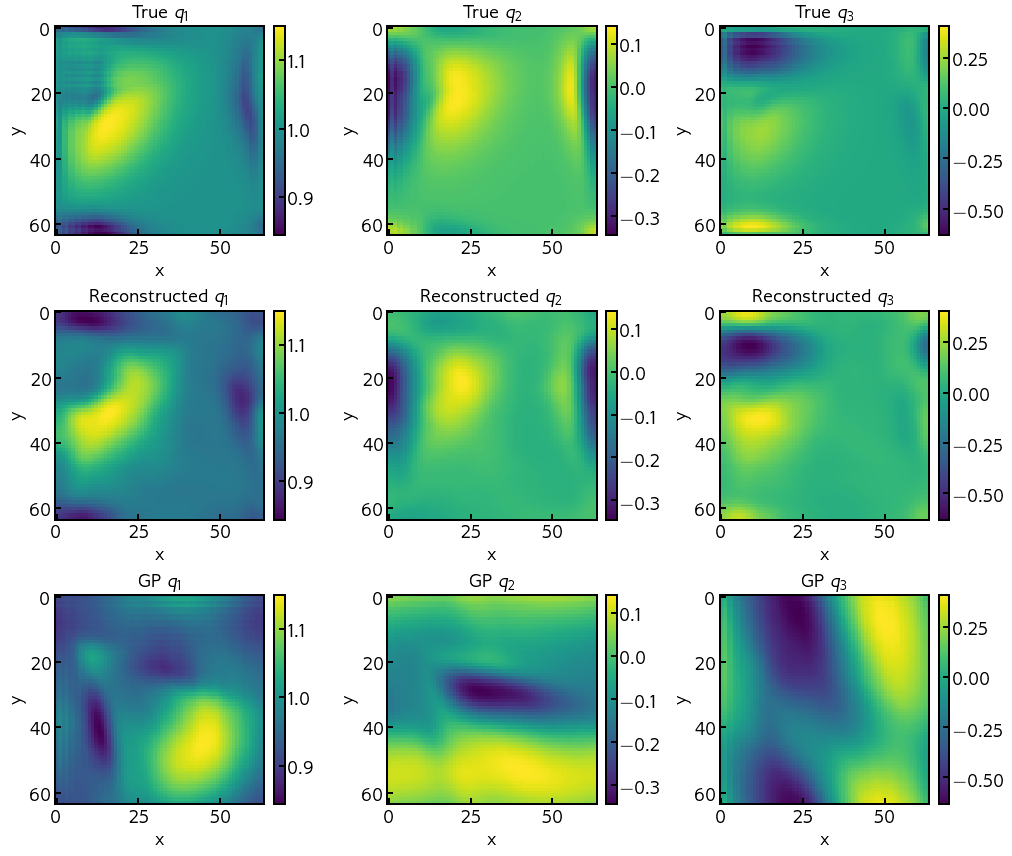

In [71]:
decoded_valid = K.eval(decoder(output_seq_pred.astype('float32')))
time = 50

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(14,12))
cs1 = ax[0,0].imshow(snapshot_test_true[time,:,:,0],label='Truth')
ax[1,0].imshow(gaussian_filter(snapshot_test_pred[time,:,:,0],sigma=2),label='Prediction')
ax[2,0].imshow(q1_snapshots_gp[:,time].reshape(64,64),label='GP')

cs2 = ax[0,1].imshow(snapshot_test_true[time,:,:,1],label='Truth')
ax[1,1].imshow(gaussian_filter(snapshot_test_pred[time,:,:,1],sigma=2),label='Prediction')
ax[2,1].imshow(q2_snapshots_gp[:,time].reshape(64,64),label='GP')

cs3 = ax[0,2].imshow(snapshot_test_true[time,:,:,2],label='Truth')
ax[1,2].imshow(gaussian_filter(snapshot_test_pred[time,:,:,2],sigma=2),label='Prediction')
ax[2,2].imshow(q3_snapshots_gp[:,time].reshape(64,64),label='GP')

for i in range(3):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[2,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[2,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[2,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

ax[2,0].set_title(r'GP $q_1$')
ax[2,1].set_title(r'GP $q_2$')
ax[2,2].set_title(r'GP $q_3$')


plt.tight_layout()
plt.savefig('CAE_GP_Contour_1.png')
plt.show()

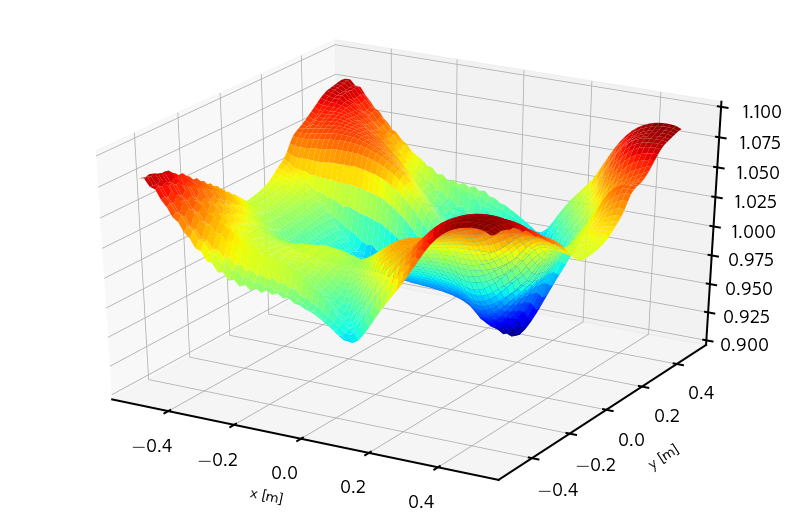

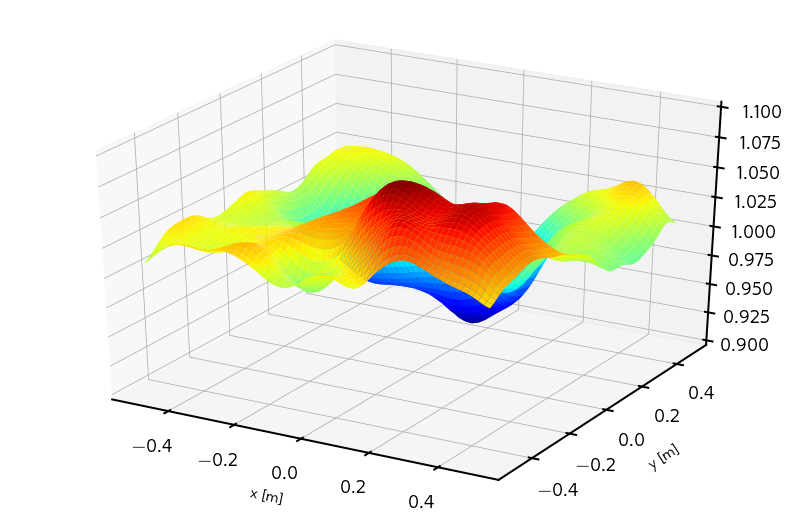

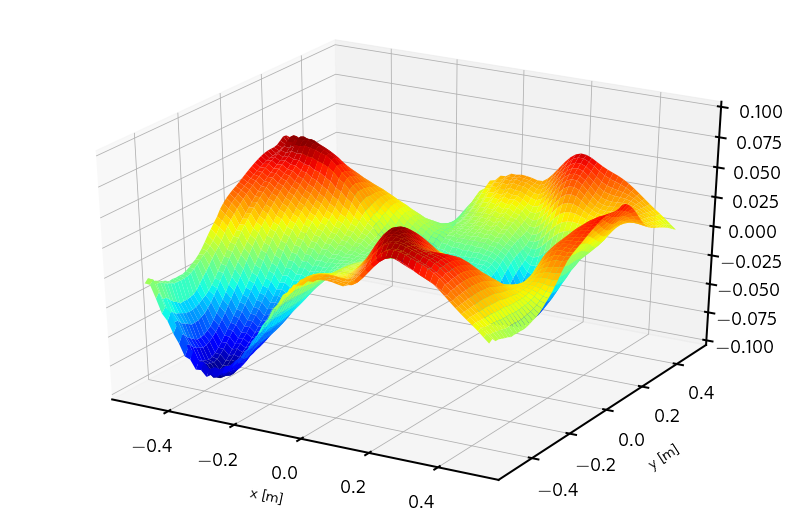

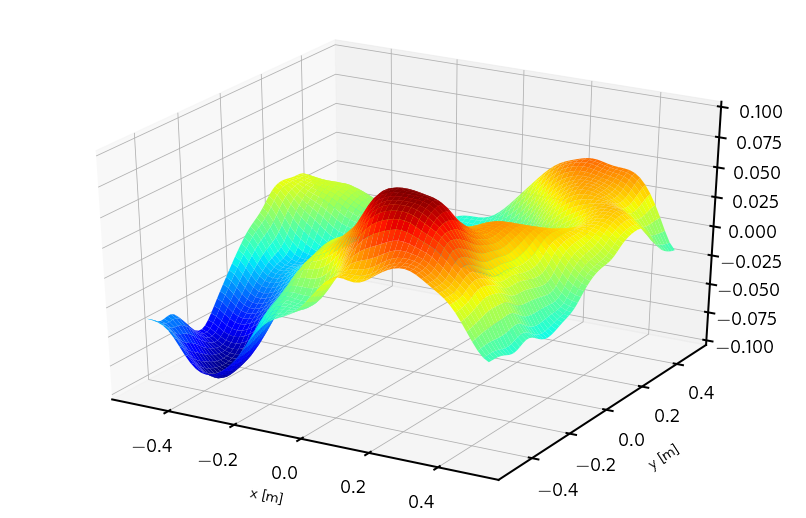

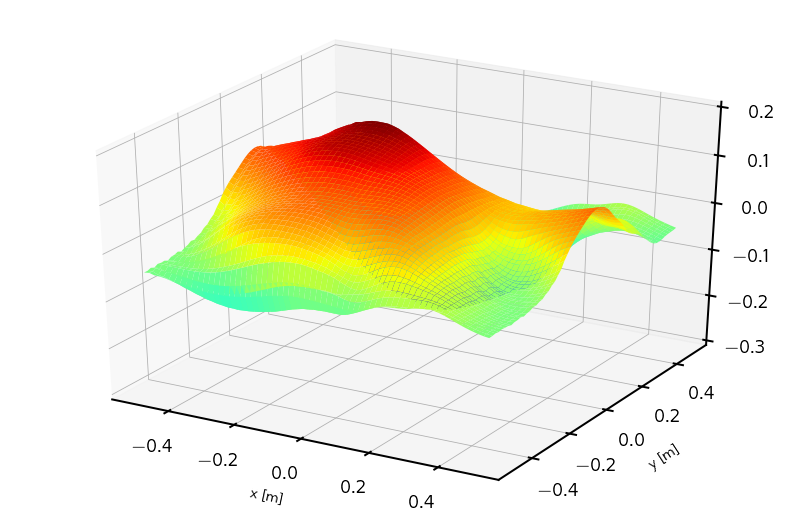

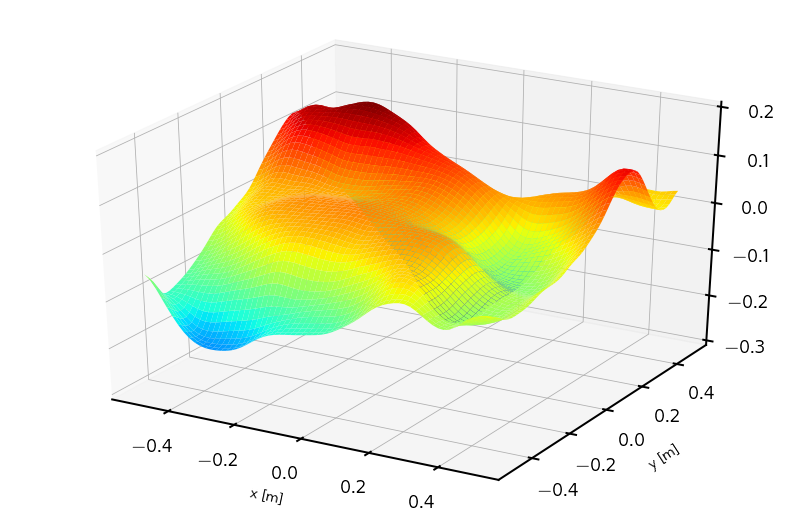

In [40]:
x = np.linspace(-1/2, 1/2, 64)  # Array with x-points
y = np.linspace(-1/2, 1/2, 64)  # Array with x-points

# Meshgrid for plotting
X, Y = np.meshgrid(x, y)
time = -1

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (11, 7))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, snapshot_test_true[time,:,:,0], rstride = 1, cstride = 1,
    cmap = plt.cm.jet, linewidth = 0, antialiased = True)

# ax.set_title('Visualization', fontname = "serif", fontsize = 17)
ax.set_xlabel('x [m]', fontsize = 16)
ax.set_ylabel('y [m]', fontsize = 16)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.tick_params(axis='both', which='major', pad=15)

# ax.set_zticks([0.1, 0.15, 0.20, 0.25, 0.3])
ax.set_zlim((0.9,1.1))

plt.savefig('True_q1_field.png')
plt.show()

fig = plt.figure(figsize = (11, 7))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, gaussian_filter(snapshot_test_pred[time,:,:,0],sigma=2), rstride = 1, cstride = 1,
    cmap = plt.cm.jet, linewidth = 0, antialiased = True)

# ax.set_title('Visualization', fontname = "serif", fontsize = 17)
ax.set_xlabel('x [m]', fontsize = 16)
ax.set_ylabel('y [m]', fontsize = 16)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

# ax.set_zticks([0.1, 0.15, 0.20, 0.25, 0.3])
ax.set_zlim((0.9,1.1))

ax.tick_params(axis='both', which='major', pad=15)
plt.savefig('Pred_q1_field.png')
plt.show()

fig = plt.figure(figsize = (11, 7))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, snapshot_test_true[time,:,:,1], rstride = 1, cstride = 1,
    cmap = plt.cm.jet, linewidth = 0, antialiased = True)

# ax.set_title('Visualization', fontname = "serif", fontsize = 17)
ax.set_xlabel('x [m]', fontsize = 16)
ax.set_ylabel('y [m]', fontsize = 16)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.tick_params(axis='both', which='major', pad=15)

# ax.set_zticks([-0.1, -0.05, 0.0, 0.05, 0.1])
ax.set_zlim((-0.1,0.1))

plt.savefig('True_q2_field.png')
plt.show()

fig = plt.figure(figsize = (11, 7))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, gaussian_filter(snapshot_test_pred[time,:,:,1],sigma=2), rstride = 1, cstride = 1,
    cmap = plt.cm.jet, linewidth = 0, antialiased = True)

# ax.set_title('Visualization', fontname = "serif", fontsize = 17)
ax.set_xlabel('x [m]', fontsize = 16)
ax.set_ylabel('y [m]', fontsize = 16)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

# ax.set_zticks([-0.1, -0.05, 0.0, 0.05, 0.1])
ax.set_zlim((-0.1,0.1))

ax.tick_params(axis='both', which='major', pad=15)
plt.savefig('Pred_q2_field.png')
plt.show()



fig = plt.figure(figsize = (11, 7))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, snapshot_test_true[time,:,:,2], rstride = 1, cstride = 1,
    cmap = plt.cm.jet, linewidth = 0, antialiased = True)

# ax.set_title('Visualization', fontname = "serif", fontsize = 17)
ax.set_xlabel('x [m]', fontsize = 16)
ax.set_ylabel('y [m]', fontsize = 16)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

ax.tick_params(axis='both', which='major', pad=15)

# ax.set_zticks([-0.2,-0.15,-0.1, -0.05, 0.0, 0.05, 0.1, 0.15,0.2])
ax.set_zlim((-0.3,0.2))

plt.savefig('True_q3_field.png')
plt.show()

fig = plt.figure(figsize = (11, 7))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, gaussian_filter(snapshot_test_pred[time,:,:,2],sigma=2), rstride = 1, cstride = 1,
    cmap = plt.cm.jet, linewidth = 0, antialiased = True)

# ax.set_title('Visualization', fontname = "serif", fontsize = 17)
ax.set_xlabel('x [m]', fontsize = 16)
ax.set_ylabel('y [m]', fontsize = 16)

ax.xaxis.labelpad=30
ax.yaxis.labelpad=30

# ax.set_zticks([-0.2,-0.15,-0.1, -0.05, 0.0, 0.05, 0.1, 0.15,0.2])
ax.set_zlim((-0.3,0.2))

ax.tick_params(axis='both', which='major', pad=15)
plt.savefig('Pred_q3_field.png')
plt.show()